This is adapted from a [pytorch tutorial](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), if you want to do more their documention is a good place to start. You have to install pytorch for this to work. Go [here](http://pytorch.org/) for instructions. If you are using Windows this might work: `conda install -c peterjc123 pytorch-cpu`, but installation is tricky. [Here](https://github.com/peterjc123/pytorch-scripts


Training a classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful.
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful.

Specifically for ``vision``, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import seaborn
import numpy as np
import scipy
import scipy.ndimage
%matplotlib inline

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../Pytorch', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../Pytorch', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

 bird  ship   car  deer


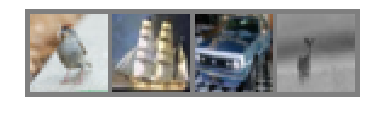

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

The images are 3 channel (RGB) so we need convolutions for each colour

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#GPUs are much better than GPUs
if torch.cuda.is_available():
    net = Net().cuda()
else:
    net = Net()

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize. This will take a little while.

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable and convert to GPU if possible
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.219
[1,  4000] loss: 1.910
[1,  6000] loss: 1.708
[1,  8000] loss: 1.591
[1, 10000] loss: 1.537
[1, 12000] loss: 1.486
[2,  2000] loss: 1.436
[2,  4000] loss: 1.400
[2,  6000] loss: 1.368
[2,  8000] loss: 1.340
[2, 10000] loss: 1.325
[2, 12000] loss: 1.312
Finished Training


## 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


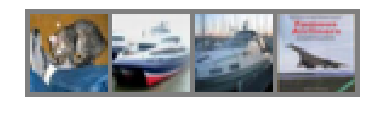

In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [8]:
#Converting back to CPU here so we don't have to do it for every tensor
if torch.cuda.is_available():
    net = net.cpu()
outputs = net(Variable(images))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [9]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j][0]] for j in range(4)))

Predicted:    cat plane   car  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [10]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 75 %
Accuracy of  bird : 46 %
Accuracy of   cat : 21 %
Accuracy of  deer : 41 %
Accuracy of   dog : 56 %
Accuracy of  frog : 73 %
Accuracy of horse : 58 %
Accuracy of  ship : 76 %
Accuracy of truck : 49 %


As we discussed in the main notebook the NN works by doing a series of convolutions to the image, whose resutls are them reduced, in his case with max pooling, adn fed to higher layers. We can see the convolution kernels the NN created with a little bit of work.

First we will conver them all to a numpy array so they are easier to handle

In [12]:
a = net.conv1.weight.data.numpy()
a.shape

(6, 3, 5, 5)

We have 6 kernels for each of the 3 colours and each kernel is 5 by 5

Colormap RGy_r is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

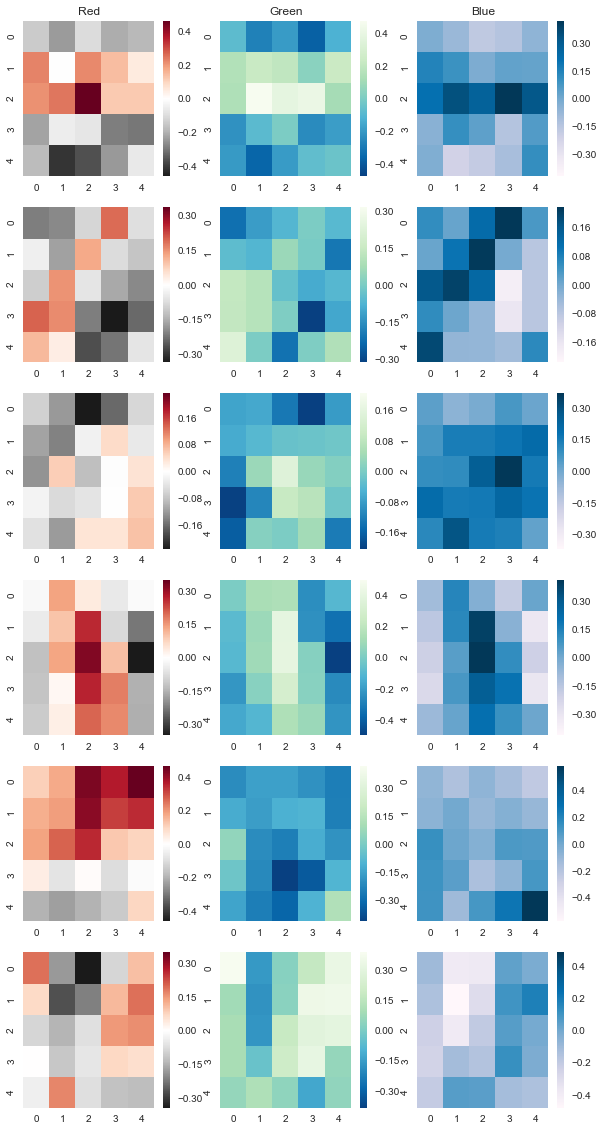

In [13]:
fig, axes = plt.subplots(ncols=a.shape[1], nrows = a.shape[0], figsize = (10, 20))

axes[0, 0].set_title("Red")
for j in range(a.shape[0]):
    seaborn.heatmap(a[j, 0,:,:],  ax = axes[j,0], cmap = 'RdGy_r')
      
        
axes[0, 1].set_title("Green")
for j in range(a.shape[0]):
    seaborn.heatmap(a[j, 1,:,:],  ax = axes[j,1], cmap = 'GnBu_r')

axes[0, 2].set_title("Blue")
for j in range(a.shape[0]):
    seaborn.heatmap(a[j, 2,:,:],  ax = axes[j,2], cmap = 'PuBu')


plt.show()

We can also look at how the comvolutions affect an image, just like we did before. Here are a few test images, with their red, green and blue channels seperated

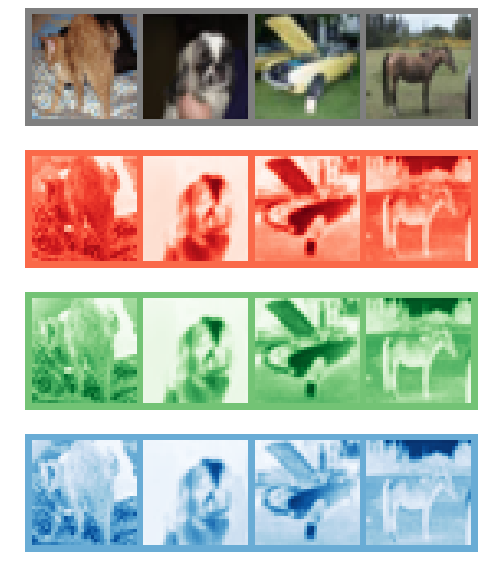

In [14]:
imgGrid = torchvision.utils.make_grid(images)
imgGrid = imgGrid / 2 + 0.5     # unnormalize
npimg = np.transpose(imgGrid.numpy(), (1, 2, 0))

fig, axes = plt.subplots(figsize = (10, 10), nrows = 4)
axes[0].imshow(npimg)
axes[0].axis('off')

colours = ["Reds", "Greens", "Blues"]

for i in range(1, 4):
    axes[i].imshow(npimg[:,:, i - 1], cmap = colours[i-1])
    axes[i].axis('off')
plt.show()

And now we can apply each convolution to each channel

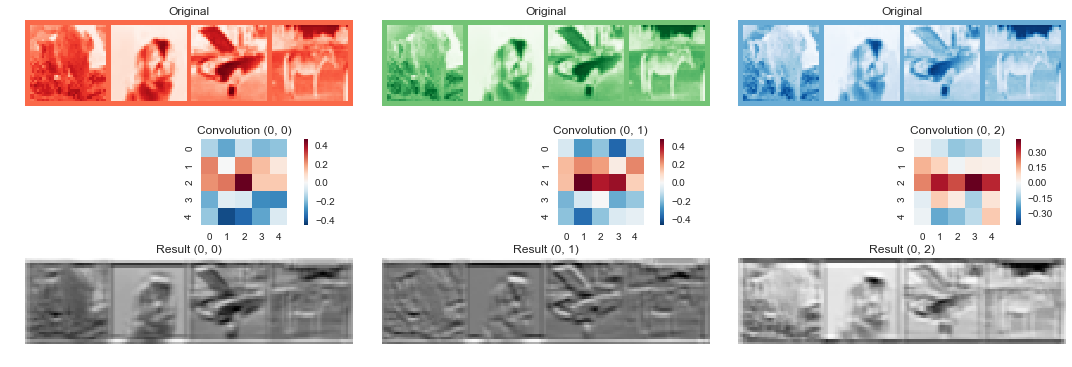

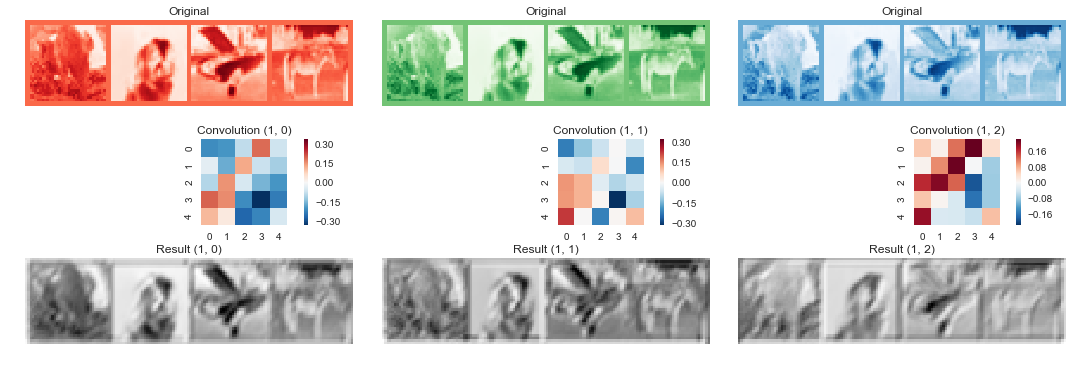

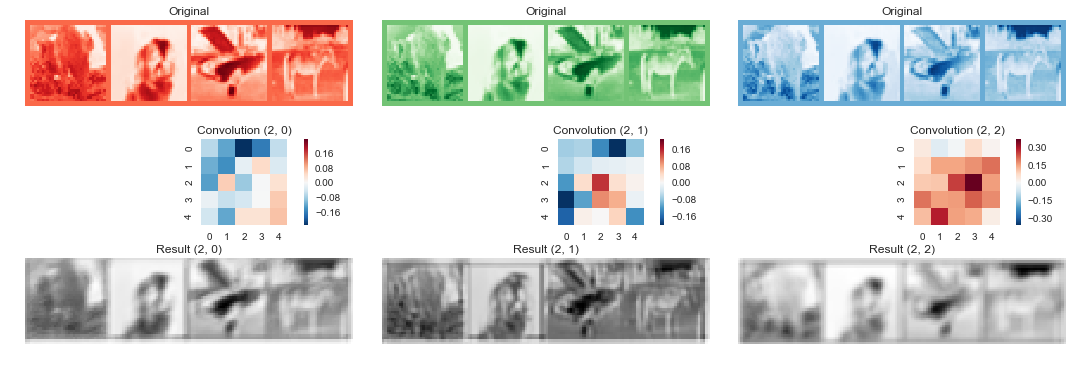

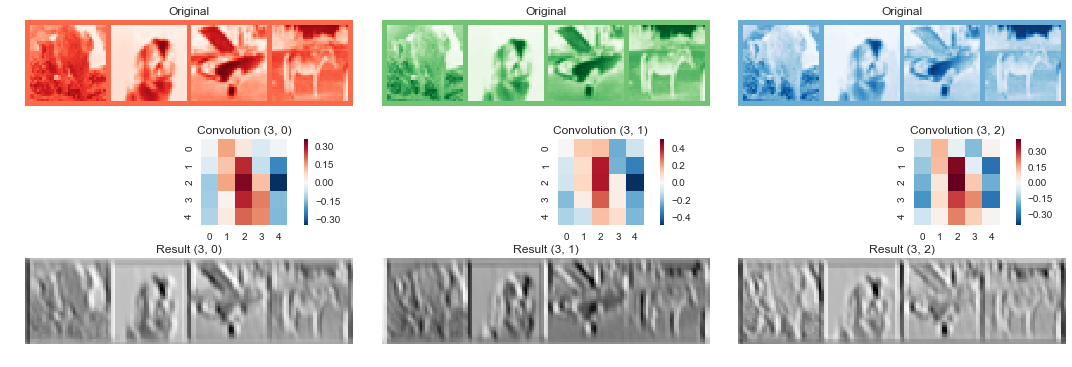

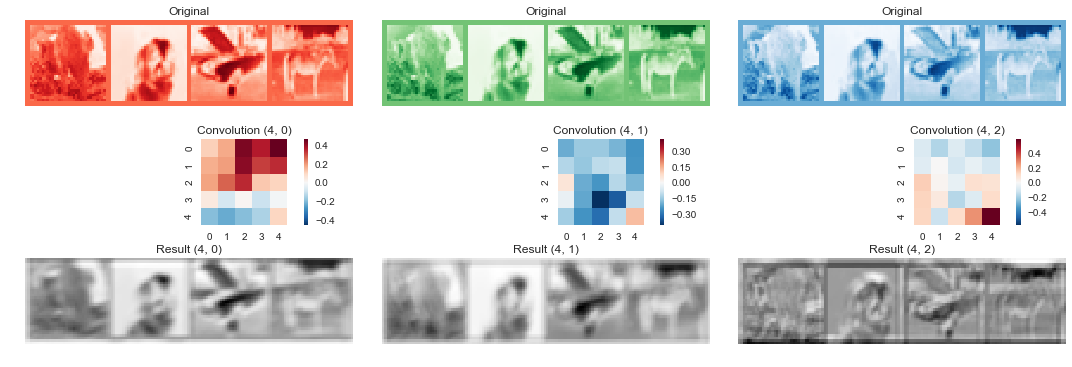

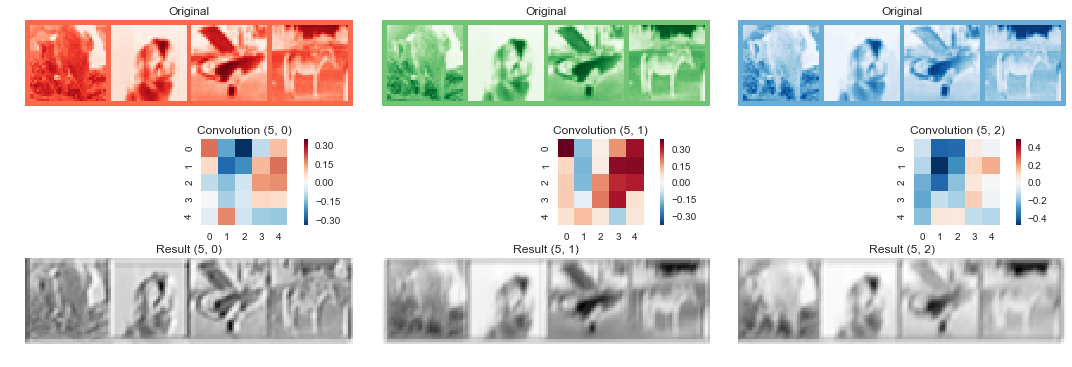

In [15]:
def normalizeConvo(a_c):
    s = np.sum(a_c.flatten())
    return a_c / s

for j in range(a.shape[0]):
    fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (15, 5))
    for i in range(3):
        convs = a[j]
        axes[0, i].imshow(npimg[:,:,i], cmap = colours[i])
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        seaborn.heatmap(convs[i], ax = axes[1,i],  square=True)
        axes[1, i].set_title("Convolution ({}, {})".format(j, i))
        axes[2, i].imshow(scipy.ndimage.convolve(npimg[:,:,i], normalizeConvo(convs[i]), mode = 'constant'))
        axes[2, i].axis('off')
        axes[2, i].set_title("Result ({}, {})".format(j, i))
    plt.tight_layout()
    plt.show()

This mess of results are the features the NN uses to start it's classifier, it actaully does a simple reduction called max pooling, where for each pixel only the results of the most intense convolutions are used. Then in the model we used another set of convolutions are applied to the results and then a normal NN layer makes the final decision. [Here](https://distill.pub/2017/feature-visualization/) is a good visualization of the further layers for a much more complex NN structure. 